In [1]:
'''An example to show how to set up an pommerman game programmatically'''
import time
import pommerman
from pommerman import agents
from pommerman import constants as c
from pommerman.configs import ffa_v0_fast_env
from pommerman.envs.v0 import Pomme
from pommerman.characters import Bomber
from pommerman import utility

# Notebook 6.3
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class NewAgent(agents.BaseAgent):
    """The Random Agent that returns random actions given an action_space."""

    def __init__(self, Character=Bomber, *args, **kwargs):
        super(NewAgent,self).__init__(Character,*args, **kwargs)
        self.seq = [c.Action.Right, c.Action.Up, c.Action.Left, c.Action.Down]
        self.index = 0
    
    def act(self, obs, action_space):
        if self.index == 4:
            self.index = 0
        action = self.seq[self.index]
        self.index += 1
        return 0
    
# Print all possible environments in the Pommerman registry
print(pommerman.REGISTRY)

# Instantiate the environment
config = ffa_v0_fast_env()
env = Pomme(**config["env_kwargs"])

# Create a set of agents (exactly four)
agent_list = [
    NewAgent(config["agent"](0, config["game_type"])),
    agents.SimpleAgent(config["agent"](1, config["game_type"])),
    agents.SimpleAgent(config["agent"](2, config["game_type"])),
    agents.RandomAgent(config["agent"](3, config["game_type"])),
    # agents.DockerAgent("pommerman/simple-agent", port=12345),
]

env.set_agents(agent_list)
env.set_training_agent(0) #<- Does not call act method on training agents in env.act
env.set_init_game_state(None)

# Run the episodes just like OpenAI Gym
#for i_episode in range(1):
#    state = env.reset()
#    done = False
#    while not done:  
#        actions = env.act(state)
#        state, reward, done, info = env.step(actions)

        #Update


#    print('Episode {} finished'.format(i_episode))
#    print(info)
#time.sleep(2)
#env.close()

    

['PommeFFACompetition-v0', 'PommeFFACompetitionFast-v0', 'PommeFFAFast-v0', 'PommeFFA-v1', 'PommeRadio-v2', 'PommeTeamCompetition-v0', 'PommeTeamCompetitionFast-v0', 'PommeTeamCompetition-v1', 'PommeTeam-v0', 'PommeTeamFast-v0']


## Notebook 6.3 Network and Train

In [2]:
class PolicyNet(nn.Module):
    """Policy network"""

    def __init__(self, n_inputs, n_hidden, n_outputs, learning_rate):
        super(PolicyNet, self).__init__()
        # network
        self.ffn = nn.Sequential(
            nn.Linear(n_inputs, n_hidden),
            nn.ReLU(),
            nn.Dropout(0.25),
            #nn.BatchNorm1d(n_hidden),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(0.25),
            #nn.BatchNorm1d(n_hidden),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            #nn.BatchNorm1d(n_hidden),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(0.25),
            #nn.BatchNorm1d(n_hidden),
            nn.Linear(n_hidden, n_outputs),
        )
        
        self.ffn.apply(self.init_weights)
        
        #self.hidden = nn.Linear(n_inputs, n_hidden)
        #self.hidden2 = nn.Linear(n_hidden, n_hidden)
        #self.out = nn.Linear(n_hidden, n_outputs)
        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = flatten_state(x)
        #print(x)
        #x = self.hidden(x)
        #x = F.relu(x)
        #x = F.relu(self.hidden2(x))
        #x = self.out(x)
        
        x = self.ffn(x)
        return F.softmax(x, dim=1)
    
    def loss(self, action_probabilities, returns):
        return -torch.mean(torch.mul(torch.log(action_probabilities), returns))
    
    def init_weights(m, *args):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)
    
def compute_returns(rewards, discount_factor):
    """Compute discounted returns."""
    returns = np.zeros(len(rewards))
    returns[-1] = rewards[-1]
    for t in reversed(range(len(rewards)-1)):
        returns[t] = rewards[t] + discount_factor * returns[t+1]
    return returns

def flatten_state(s):
    #print("\n Flatten: ",s)
    return torch.from_numpy(np.array([flatten_state_aux(x) for x in s])).float()

def flatten_state_aux(s):
    # Lists
    #print("\n Augs: ",s)
    alive = [1 if x in s['alive'] else 0 for x in range(10,14)]
    #print(alive)
    board = s['board']
    bomb_blast_strength = s['bomb_blast_strength']
    bomb_life = s['bomb_life']
    # Tuples
    position = s['position']
    # Ints
    blast_strength = s['blast_strength']
    can_kick = s['can_kick']
    ammo = s['ammo']
    # Enums
    teammate = s['teammate'] #9 for FFA
    enemies = s['enemies'] #11,12,13 for FFA and training agent id = 0
    
    a = np.append(np.array(alive),np.array(board).flatten())
    a = np.append(a,np.array(bomb_blast_strength).flatten())
    a = np.append(a,np.array(bomb_life).flatten())
    a = np.append(a,position[0])
    a = np.append(a,position[1])
    a = np.append(a,blast_strength)
    a = np.append(a,can_kick)
    a = np.append(a,ammo)
    # Commented out as we get size 376 but expected 372. I guess we calculated wrong
    #a = np.append(a,teammate.value)
    #a = np.append(a,[e.value for e in enemies])
    #print(np.shape(a))
    return a.astype(float)
    

# training settings
n_inputs = 372
n_hidden = 500
n_outputs = env.action_space.n

num_episodes = 30
#rollout_limit = env.spec.timestep_limit # max rollout length
discount_factor = 0.9 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.001 # you know this by now
val_freq = 5 # validation frequency

# setup policy network

policy = PolicyNet(n_inputs, n_hidden, n_outputs, learning_rate)

# train policy network

try:
    training_rewards, losses = [], []
    print('start training')
    for i in range(num_episodes):
        rollout = []
        s = env.reset()
        done = False
        policy.train()
        while not done:
            # generate rollout by iteratively evaluating the current policy on the environment
            with torch.no_grad():
                a_prob = policy(np.atleast_1d(s[0]))
            a = (np.cumsum(a_prob.numpy()) > np.random.rand()).argmax() # sample action
            
            actions = env.act(s)
            actions.insert(0,a)
            
            #print(actions)
            
            s1, r, done, _ = env.step(actions)
            #print(r)
            rollout.append((s, a, r[0]))
            #print("\n\nrollout:",rollout,"\n\n")
            s = s1
        # prepare batch
        print('done with episode:',i)
        rollout = np.array(rollout)
        states = np.vstack(rollout[:,0])
        actions = np.vstack(rollout[:,1])
        rewards = np.array(rollout[:,2], dtype=float)
        returns = compute_returns(rewards, discount_factor)
        # policy gradient update
        policy.optimizer.zero_grad()
        a_probs = policy([s[0] for s in states]).gather(1, torch.from_numpy(actions)).view(-1)
        loss = policy.loss(a_probs, torch.from_numpy(returns).float())
        loss.backward()
        policy.optimizer.step()
        # bookkeeping
        training_rewards.append(sum(rewards))
        losses.append(loss.item())
        policy.eval()
        # print
        if (i+1) % val_freq == 0:
            # validation
            validation_rewards = []
            for _ in range(1):
                s = env.reset()
                reward = 0
                done = False
                while not done:
                    env.render()
                    with torch.no_grad():
                        probs = policy(np.atleast_1d(s[0]))
                        a = probs.argmax().item()
                        print(probs, "max actions: ", a,probs.argmax())
                        
                    actions = env.act(s)
                    actions.insert(0,a)
                    
                    s, r, done, _ = env.step(actions)
                    reward += r[0]
                validation_rewards.append(reward)
                env.render(close=True)
            print('{:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(validation_rewards), np.mean(losses[-val_freq:])))
            time.sleep(2)
    env.close()
    print('done')
except KeyboardInterrupt:
    print('interrupt')    

start training
done with episode: 0
done with episode: 1
done with episode: 2
done with episode: 3
done with episode: 4
tensor([[0.1141, 0.1192, 0.2353, 0.1097, 0.2979, 0.1237]]) max actions:  4 tensor(4)
tensor([[0.1199, 0.1202, 0.2274, 0.1121, 0.2923, 0.1280]]) max actions:  4 tensor(4)
tensor([[0.1171, 0.1235, 0.2258, 0.1161, 0.2916, 0.1259]]) max actions:  4 tensor(4)
tensor([[0.1119, 0.1252, 0.2281, 0.1121, 0.2935, 0.1291]]) max actions:  4 tensor(4)
tensor([[0.1148, 0.1240, 0.2243, 0.1122, 0.2914, 0.1335]]) max actions:  4 tensor(4)
tensor([[0.1204, 0.1233, 0.2289, 0.1139, 0.2844, 0.1290]]) max actions:  4 tensor(4)
tensor([[0.1212, 0.1239, 0.2283, 0.1147, 0.2822, 0.1297]]) max actions:  4 tensor(4)
tensor([[0.1186, 0.1268, 0.2263, 0.1119, 0.2844, 0.1320]]) max actions:  4 tensor(4)
tensor([[0.1190, 0.1271, 0.2258, 0.1125, 0.2830, 0.1326]]) max actions:  4 tensor(4)
tensor([[0.1194, 0.1274, 0.2254, 0.1129, 0.2819, 0.1330]]) max actions:  4 tensor(4)
tensor([[0.1198, 0.1276, 0.225

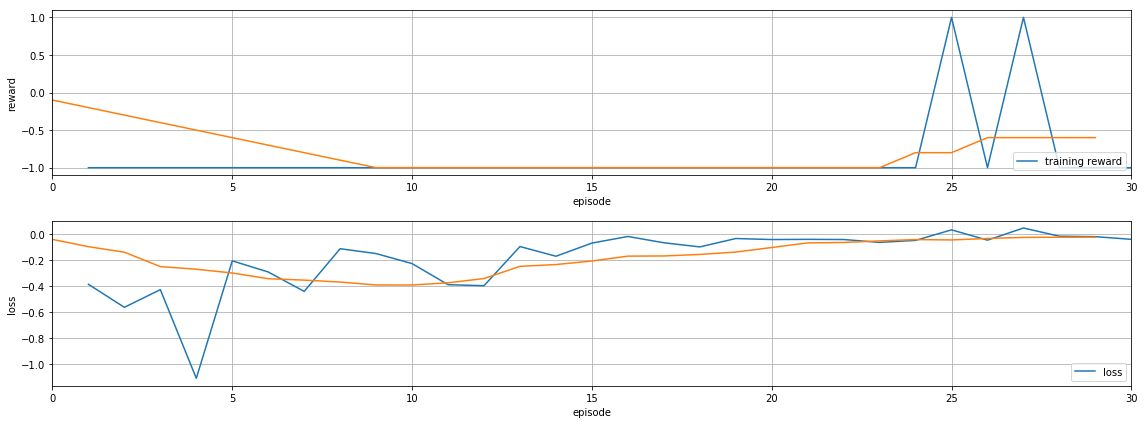

In [88]:
# plot results
import matplotlib.pyplot as plt

def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,6))
plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()